In [1]:
# Import bibliotecas
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para modelagem
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Função leitura dos dados
def read_wind_data(dir_name='Datathons_pem_vento'):
    """
    Função que faz leitura de todos os arquivos de dados de ventos e retorna um dataframe contendo todos os dados.
    Presume-se que os dados de vento são em intervalos de meia hora.
    A pasta precisa ter apenas arquivos de vento, formato txt.
    
    Args:
        dir_name (str, optional): string com o nome do diretório onde os dados estão
        
    Returns:
        df: pandas dataframe contendo as informações dos arquivos lidos.
            Cada coluna é uma usina e os index das linha são timestamps, ordenados.
    """
    path = os.path.join(os.getcwd(), dir_name)
    df = pd.DataFrame()
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('txt'):
                df_temp = pd.read_csv(file_path, header=None, sep=';')
                df_temp[0] = pd.to_datetime(df_temp[0], format='%Y%m%d')
                df_temp.set_index(0, drop=True, inplace=True)
                init_date = df_temp.index[0]
                last_date = df_temp.index[-1] + timedelta(days=1) - timedelta(minutes=30)
                df_temp = df_temp.stack(dropna=False)
                df_temp.index = pd.date_range(init_date, last_date, freq='30T')
                df = pd.concat([df, pd.DataFrame(df_temp, columns=[file])], axis=1)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [3]:
data = read_wind_data()
data

,U10_Ven_Prev.txt,U10_Ven_Verif.txt,U11_Ven_Prev.txt,U11_Ven_Verif.txt,U12_Ven_Prev.txt,U12_Ven_Verif.txt,U13_Ven_Prev.txt,U13_Ven_Verif.txt,U14_Ven_Prev.txt,U14_Ven_Verif.txt,...,U5_Ven_Prev.txt,U5_Ven_Verif.txt,U6_Ven_Prev.txt,U6_Ven_Verif.txt,U7_Ven_Prev.txt,U7_Ven_Verif.txt,U8_Ven_Prev.txt,U8_Ven_Verif.txt,U9_Ven_Prev.txt,U9_Ven_Verif.txt
2017-01-01 00:00:00,3.8796,3.2332,NaN,1.2080,NaN,1.1268,NaN,1.7056,NaN,1.9205,...,2.9649,3.0499,2.6004,4.4208,4.5385,3.7831,4.7348,3.2173,4.5700,3.2301
2017-01-01 00:30:00,3.8306,3.0635,NaN,1.0023,NaN,0.6833,NaN,1.8107,NaN,2.2813,...,2.9316,2.7315,2.5076,4.4953,4.5385,3.4434,4.5437,3.2036,4.5069,3.1167
2017-01-01 01:00:00,3.7815,2.7986,NaN,0.8058,NaN,0.7950,NaN,3.8786,NaN,2.7579,...,2.8983,2.4952,2.4147,3.8723,4.5385,3.7608,4.3527,3.3689,4.4439,2.7939
2017-01-01 01:30:00,3.7377,3.0123,NaN,1.0192,NaN,1.1210,NaN,3.7506,NaN,2.7623,...,2.9053,2.8445,2.3656,3.5962,4.4579,3.0795,4.1530,3.7987,4.3843,2.7652
2017-01-01 02:00:00,3.6939,2.9413,NaN,1.0742,NaN,1.0895,NaN,2.6184,NaN,2.3249,...,2.9123,2.9139,2.3166,3.5529,4.3773,2.7538,3.9532,3.9098,4.3247,2.8384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,3.1840,2.8725,2.0309,1.5289,1.0023,1.8960,1.6787,1.2904,1.7821,1.4464,...,2.4182,3.1559,3.1577,4.2607,2.9018,2.7038,3.1121,3.1995,4.2213,2.8216
2020-12-31 22:00:00,3.0701,2.3312,1.9381,1.1669,0.9252,1.6594,1.5701,0.8090,1.6682,1.2822,...,2.2570,3.0932,2.9965,3.9901,3.2137,2.7238,3.4275,3.2473,4.1320,2.6242
2020-12-31 22:30:00,3.0297,2.5118,1.6542,0.7361,0.9042,1.6658,1.4124,0.5454,1.3703,1.2373,...,2.0975,2.7557,2.6828,3.9751,3.3171,3.0499,3.6501,3.6175,3.8726,2.8661
2020-12-31 23:00:00,2.9894,2.9362,1.3703,0.9284,0.8832,1.5034,1.2547,0.9915,1.0724,1.2548,...,1.9381,2.9703,2.3691,3.9582,3.4205,3.1400,3.8726,3.4096,3.6133,3.3746


# Modelo SARIMA

Vamos aplicar o modelo ARIMA/SARIMA, para modelar o viés. Portanto, nossa série temporal será o erro do modelo de previsão. Vamos começar trabalhando apenas com uma usina (U1) e posteriormente iremos expandir e analisar para as demais.

In [4]:
df_u1 = data[['U1_Ven_Verif.txt', 'U1_Ven_Prev.txt']]

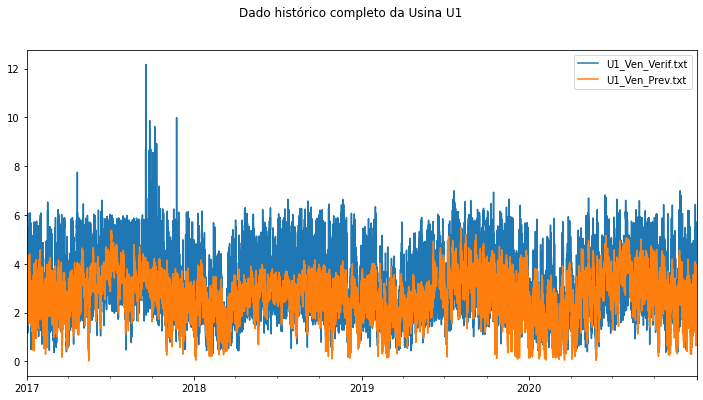

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
df_u1.plot(ax=ax)
fig.suptitle('Dado histórico completo da Usina U1')
plt.show()

In [6]:
df_u1.loc[:, 'vies'] = df_u1['U1_Ven_Verif.txt'] - df_u1['U1_Ven_Prev.txt']

/home/silas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/silas/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
df_u1

,U1_Ven_Verif.txt,U1_Ven_Prev.txt,vies
2017-01-01 00:00:00,3.2928,2.9088,0.3840
2017-01-01 00:30:00,4.6450,2.7862,1.8588
2017-01-01 01:00:00,4.4030,2.6635,1.7395
2017-01-01 01:30:00,4.4062,2.5356,1.8706
2017-01-01 02:00:00,4.9379,2.4077,2.5302
...,...,...,...
2020-12-31 21:30:00,2.8684,2.5969,0.2715
2020-12-31 22:00:00,2.9722,2.9404,0.0318
2020-12-31 22:30:00,2.8980,2.9930,-0.0950
2020-12-31 23:00:00,2.6601,3.0455,-0.3854


In [8]:
# Substituindo vies NAN pela mediana
df_u1.loc[:, 'vies'].fillna(df_u1['vies'].median(), inplace=True)

/home/silas/.local/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


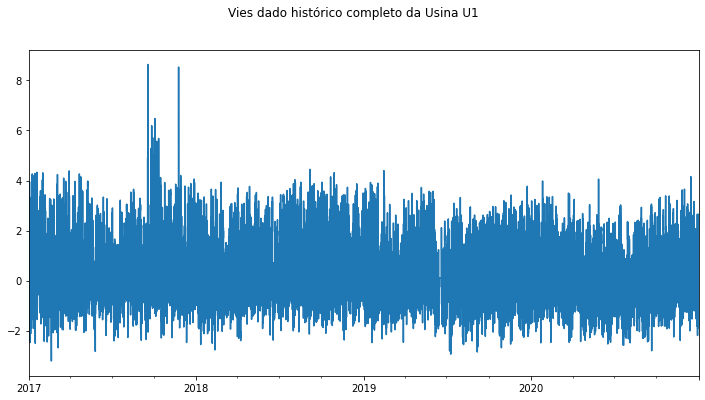

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
df_u1['vies'].plot(ax=ax)
fig.suptitle('Vies dado histórico completo da Usina U1')
plt.show()

# Primeira análise

Vamos começar analisando com dados de 1 mês de treinamento e previsão de 10 dias. Estamos nos baseando nos dados repassados pelo documento "Modelo_de_correco_de_vies_da_previso_de_vento_do_ONS", onde cita que, para os modelos empregados pela ONS, esses janelamentos foram os melhores. Posteriormente iremos estudar outras janelas.

Decidimos por começar utilizando o mês de nov/2020 como treinamento para prever os 10 primeiros dias de dez/2020, iremos expandir a seguir.

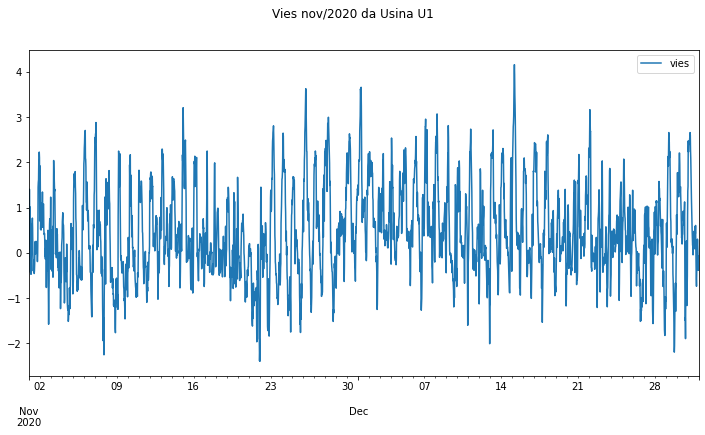

In [10]:
df = df_u1[df_u1.index >= '2020-11-01'][['vies']]

fig, ax = plt.subplots(figsize=(12,6))
df.plot(ax=ax)
fig.suptitle('Vies nov/2020 da Usina U1')
plt.show()

In [11]:
train = df[df.index < '2020-12-01']
test = df[df.index >= '2020-12-01']

# Analise estacionariedade do sinal

In [12]:
def adfuller_test(data):
    result = adfuller(data)

    print('Results of Dickey-Fuller Test:')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('#Lags used: {}'.format(result[2]))
    print('#Observations used: {}'.format(result[3]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [13]:
# 48 pontos corresponde a 24h, ou um dia
rolling_mean = train.rolling(window = 48).mean()
rolling_std = train.rolling(window = 48).std()

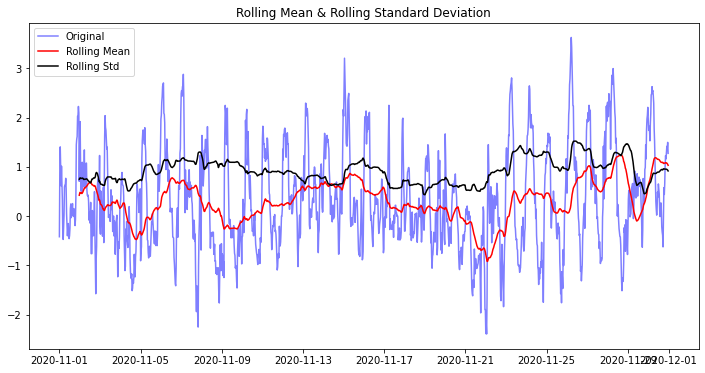

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(train, color = 'blue', label = 'Original', alpha=0.5)
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [15]:
adfuller_test(train)

Results of Dickey-Fuller Test:
ADF Statistic: -9.50335301139156
p-value: 3.3983433554294535e-16
#Lags used: 16
#Observations used: 1423
Critical Values:
	1%: -3.434953749425684
	5%: -2.8635732362456845
	10%: -2.567852483484606


A análise gráfica mostra que a média diária do viés flutua bastante, mas parece não apresentar uma tendência ou padrão. Isso é confirmado pelo teste adfuller, que apresenta valor p da ordem de 10e-16.

# Gráficos de correlograma e correlograma parcial

Analisamos agora ACF e PACF para os parâmetros e identificar se iremos empregar modelo ARIMA ou SARIMA

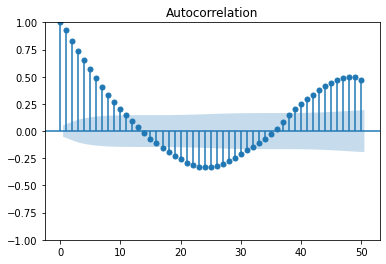

In [16]:
plot_acf(train, lags=50)
plt.show()

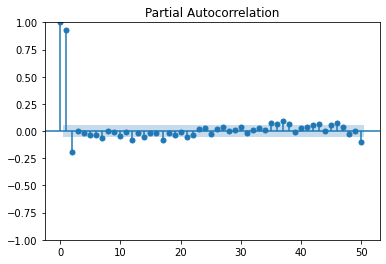

In [17]:
plot_pacf(train, method='ywm', lags=50)
plt.show()

O gráfico de acf mostra que o sinal não é estacionário e possui informações que devem ser removidas. Vamos analisar o sinal em sua primeira derivada.

## 1a derivada

In [18]:
train_diff = train.diff()
train_diff = train_diff.dropna()

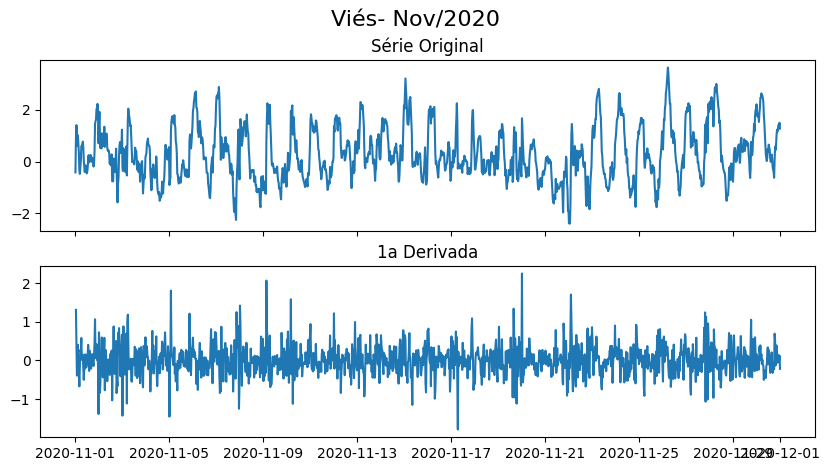

In [19]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Original
axes[0].plot(train)
axes[0].set_title('Série Original')

# Seasonal
axes[1].plot(train_diff)
axes[1].set_title('1a Derivada')
plt.suptitle('Viés- Nov/2020', fontsize=16)
plt.show()

In [20]:
adfuller_test(train_diff)

Results of Dickey-Fuller Test:
ADF Statistic: -11.32560419250231
p-value: 1.1455618208211097e-20
#Lags used: 24
#Observations used: 1414
Critical Values:
	1%: -3.4349831053858746
	5%: -2.863586191208161
	10%: -2.567859382293453


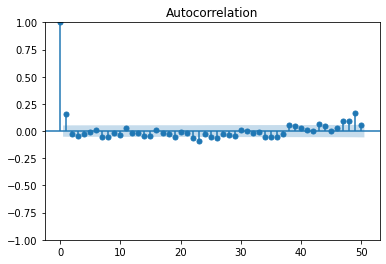

In [21]:
plot_acf(train_diff, lags=50)
plt.show()

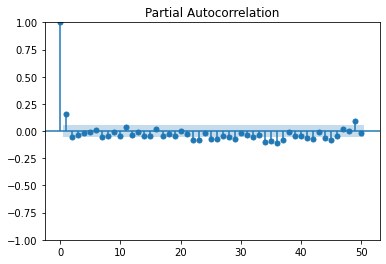

In [22]:
plot_pacf(train_diff, method='ywm', lags=50)
plt.show()

Com esses resultados, nosso modelo inicial será um ARIMA com derivada e parâmetros P e Q = 1.

# ARIMA (p,d,q) = (0,1,1)

In [23]:
model = SARIMAX(train, order=(0,1,1))
model = model.fit()

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   vies   No. Observations:                 1440
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -660.664
Date:                Sun, 26 Jun 2022   AIC                           1325.329
Time:                        15:44:05   BIC                           1335.872
Sample:                    11-01-2020   HQIC                          1329.265
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1643      0.020      8.229      0.000       0.125       0.203
sigma2         0.1467      0.003     42.683      0.000       0.140       0.153
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               612.42
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

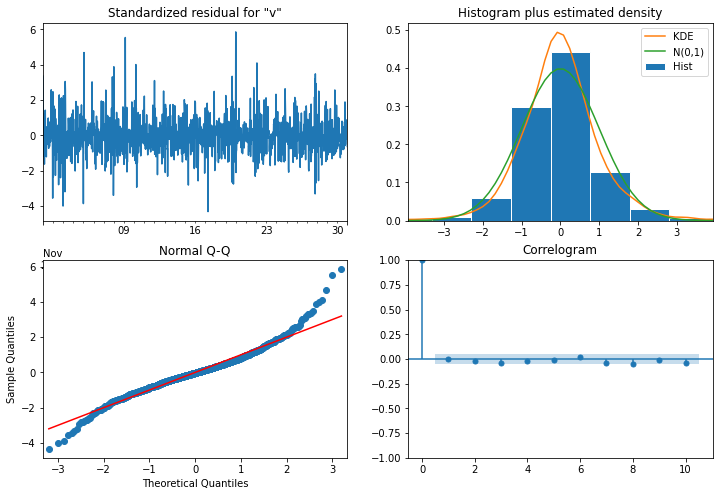

In [25]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

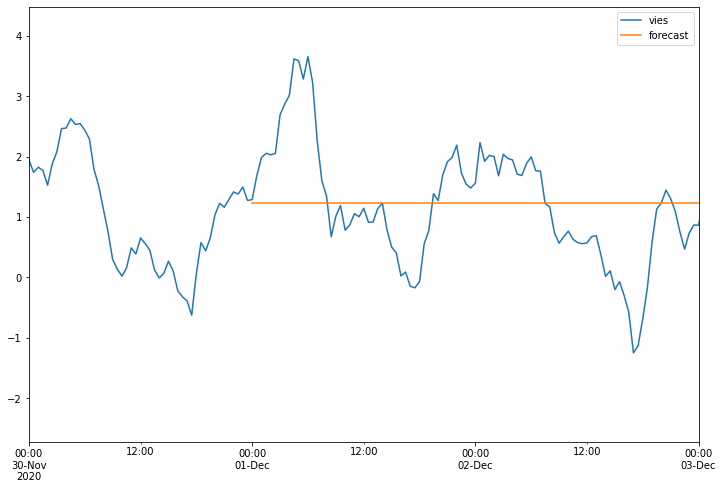

In [26]:
df['forecast'] = model.predict(start='2020-12-01', end='2020-12-10', dynamic=True)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-30', '2020-12-03'])
plt.show()

In [27]:
df

,vies,forecast
2020-11-01 00:00:00,-0.4182,NaN
2020-11-01 00:30:00,0.8832,NaN
2020-11-01 01:00:00,1.4046,NaN
2020-11-01 01:30:00,1.0087,NaN
2020-11-01 02:00:00,0.6152,NaN
...,...,...
2020-12-31 21:30:00,0.2715,NaN
2020-12-31 22:00:00,0.0318,NaN
2020-12-31 22:30:00,-0.0950,NaN
2020-12-31 23:00:00,-0.3854,NaN


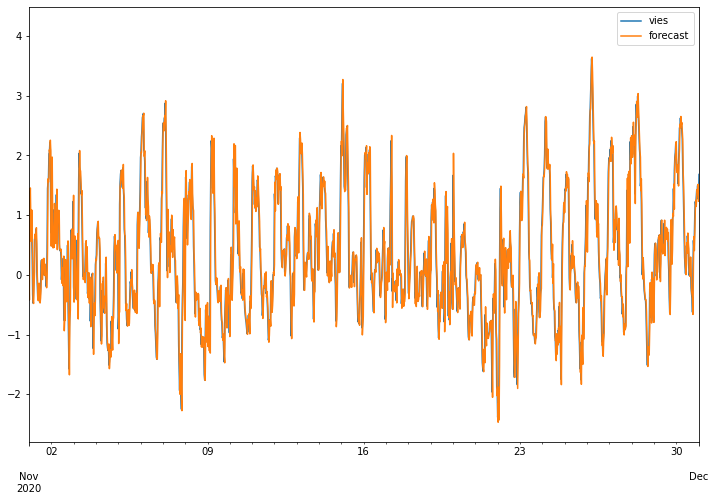

In [28]:
# Previsao in-sample 1 passo a frente
df['forecast'] = model.predict(start='2020-11-01', end='2020-12-01', dynamic=False)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-01', '2020-12-01'])
plt.show()

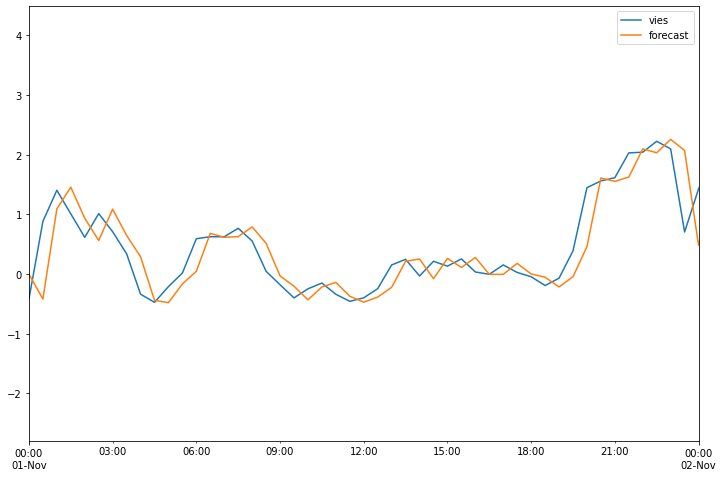

In [29]:
# Previsao in-sample 1 passo a frente
df['forecast'] = model.predict(start='2020-11-01', end='2020-12-01', dynamic=False)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-01', '2020-11-02'])
plt.show()

# Modelo SARIMAX

Decomposição do viés em trend (tendência), seasonal (sazonal) e resid (resíduo/erro).

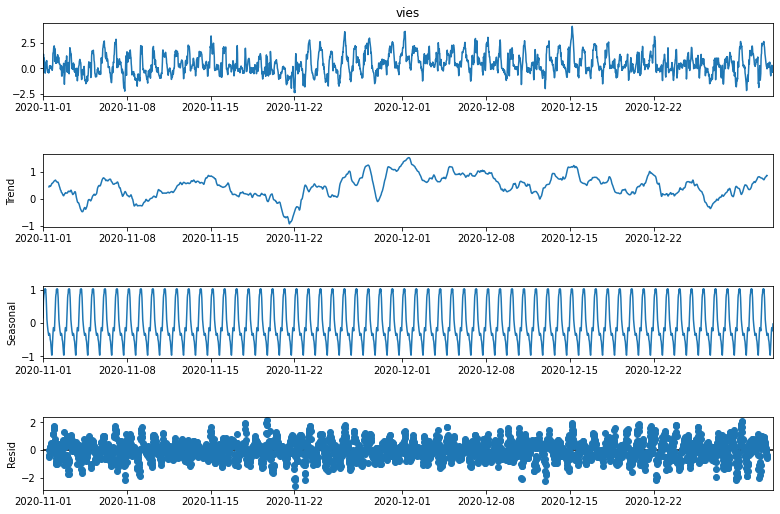

In [30]:
seasonal = seasonal_decompose(df['vies'], model='additive', period=48)
fig = seasonal.plot()
fig.set_size_inches((12, 8))
plt.show()

In [31]:
df = df_u1[df_u1.index >= '2020-11-01'][['vies']]
df.loc[:,'trend'] = df['vies'].diff(48)
df = df.dropna()

train = df[df.index < '2020-12-01']
test = df[df.index >= '2020-12-01']

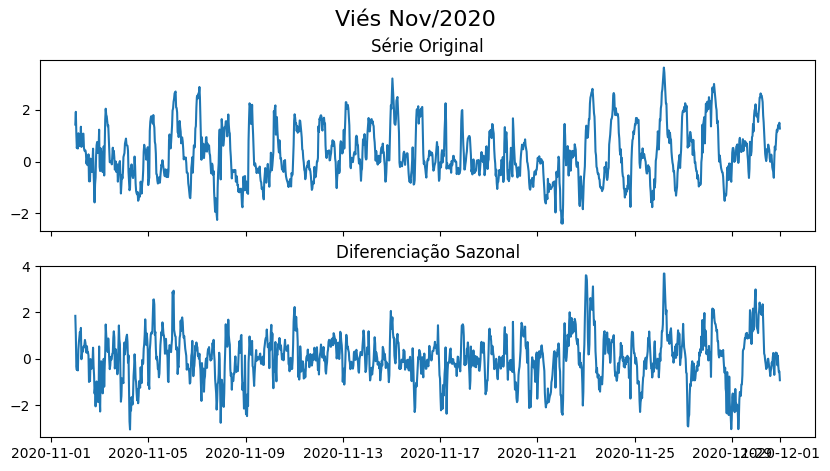

In [32]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Original
axes[0].plot(train['vies'])
axes[0].set_title('Série Original')

# Seasonal
axes[1].plot(train['trend'])
axes[1].set_title('Diferenciação Sazonal')
plt.suptitle('Viés Nov/2020', fontsize=16)
plt.show()

# Teste de estacionariedade

In [33]:
# 48 pontos corresponde a 24h, ou um dia
rolling_mean = train['trend'].rolling(window = 48).mean()
rolling_std = train['trend'].rolling(window = 48).std()

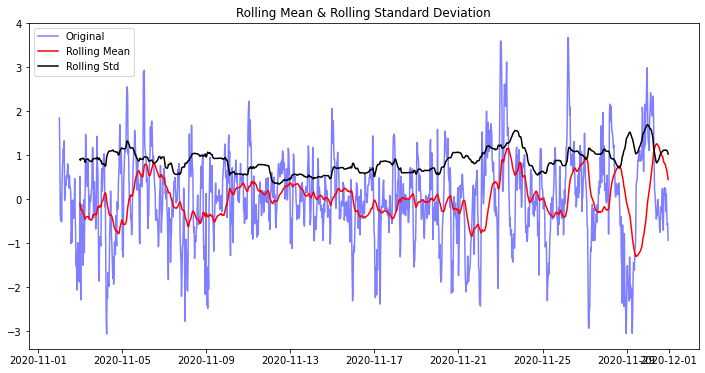

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(train['trend'], color = 'blue', label = 'Original', alpha=0.5)
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [35]:
adfuller_test(train['trend'])

Results of Dickey-Fuller Test:
ADF Statistic: -7.267452010898051
p-value: 1.6209901372686905e-10
#Lags used: 10
#Observations used: 1381
Critical Values:
	1%: -3.435094023613352
	5%: -2.863635138949194
	10%: -2.567885448250043


# Gráficos de correlograma e correlograma parcial

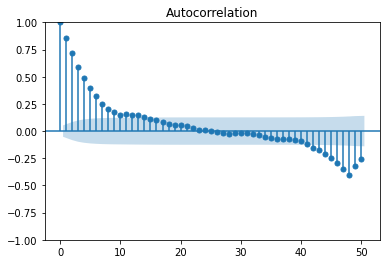

In [36]:
plot_acf(train['trend'], lags=50)
plt.show()

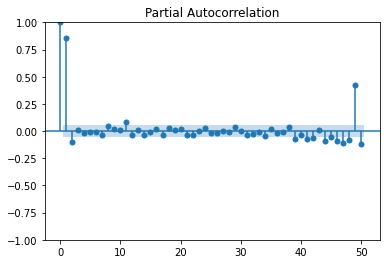

In [37]:
plot_pacf(train['trend'], method='ywm', lags=50)
plt.show()

# SARIMA (p,d,q)(P,D,Q,s) = (0,1,1)(1,1,1,48)

In [38]:
model = SARIMAX(train['vies'], order=(0,1,1), seasonal_order=(1,1,1,48))
model = model.fit()

In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               vies   No. Observations:                 1392
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 48)   Log Likelihood                -662.899
Date:                            Sun, 26 Jun 2022   AIC                           1333.797
Time:                                    15:47:09   BIC                           1354.608
Sample:                                11-02-2020   HQIC                          1341.593
                                     - 11-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1168      0.021      5.609      0.000       0.076       0.158
ar.S.L48       0.0325      0.029      1.112      0.266      -0.025       0.090
ma.S.L48      -0.9962      0.318     -3.131      0.002      -1.620      -0.373
sigma2         0.1402      0.043      3.266      0.001       0.056       0.224
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               458.26
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.38
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

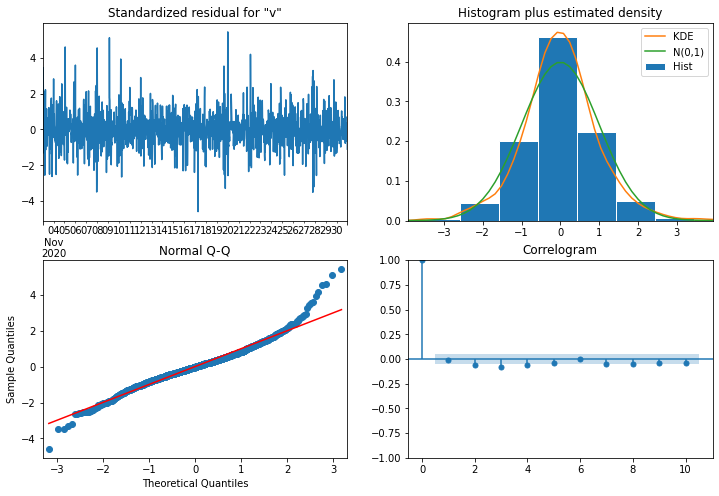

In [40]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

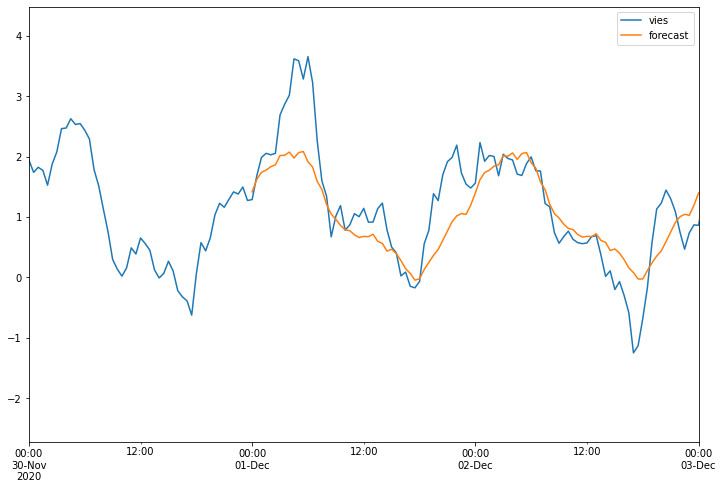

In [41]:
df['forecast'] = model.predict(start='2020-12-01', end='2020-12-03', dynamic=True)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-30', '2020-12-03'])
plt.show()

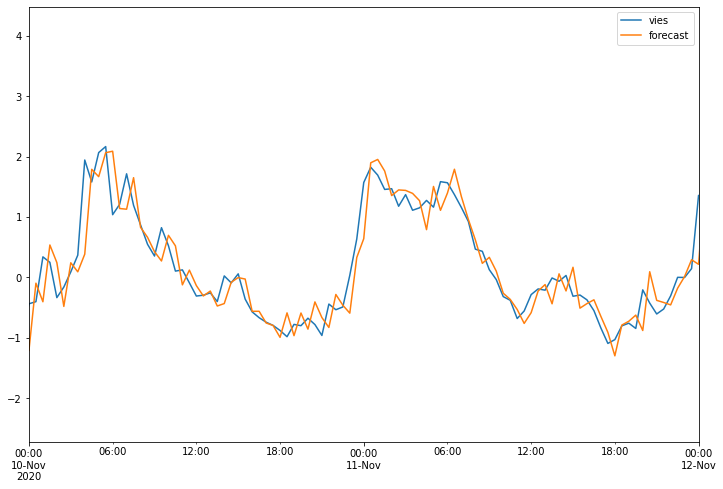

In [42]:
# Previsao in-sample 1 passo a frente
df['forecast'] = model.predict(start='2020-11-10', end='2020-11-12', dynamic=False)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-10', '2020-11-12'])
plt.show()

# Grid Search pelos melhores parametros

Grid Search em modelos SARIMA, com p=P=0,1,2, q=Q=0,1,2 e d=D=0

In [43]:
results = []
for p in range(3):
    for q in range(3):
        d = 0
        print(f"Model: {p}, {d}, {q}")
        try:
            model = SARIMAX(train['vies'], order=(p,d,q), seasonal_order=(p,d,q,48))
            model = model.fit(disp=False)
            
            results.append((p, d, q, model.aic, model.bic))
        except:
            results.append((p, d, q, None, None))
results = pd.DataFrame(results)

Model: 0, 0, 0
Model: 0, 0, 1


/home/silas/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model: 0, 0, 2


/home/silas/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model: 1, 0, 0
Model: 1, 0, 1
Model: 1, 0, 2
Model: 2, 0, 0
Model: 2, 0, 1


/home/silas/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model: 2, 0, 2


In [44]:
results.to_csv("results.csv")

In [46]:
results.columns = ["p", "d", "q", "BIC", "AIC"]
results.sort_values('BIC')

,p,d,q,BIC,AIC
4,1,0,1,1179.548416,1205.740900
5,1,0,2,1181.809955,1218.479433
7,2,0,1,1181.871033,1218.540511
8,2,0,2,1187.038919,1234.185390
6,2,0,0,1199.809531,1226.002016
3,1,0,0,1247.549566,1263.265056
2,0,0,2,1912.000569,1938.193053
1,0,0,1,2588.407555,2604.123046
0,0,0,0,4126.337899,4131.576396


# Melhor modelo SARIMA: (p,d,q)(P,D,Q,s) = (1,1,1)(1,1,1,48)

In [57]:
model = SARIMAX(train['vies'], order=(1,1,1), seasonal_order=(1,1,1,48))
model = model.fit()

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               vies   No. Observations:                 1392
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 48)   Log Likelihood                -661.672
Date:                            Sun, 26 Jun 2022   AIC                           1333.345
Time:                                    16:33:55   BIC                           1359.358
Sample:                                11-02-2020   HQIC                          1343.089
                                     - 11-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2436      0.177     -1.377      0.169      -0.590       0.103
ma.L1          0.3574      0.170      2.100      0.036       0.024       0.691
ar.S.L48       0.0321      0.029      1.100      0.271      -0.025       0.089
ma.S.L48      -0.9930      0.172     -5.762      0.000      -1.331      -0.655
sigma2         0.1404      0.023      6.201      0.000       0.096       0.185
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               450.41
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.38
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

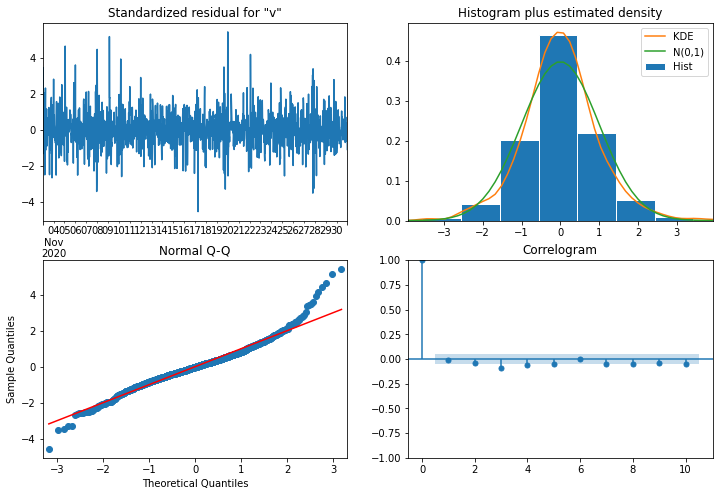

In [59]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

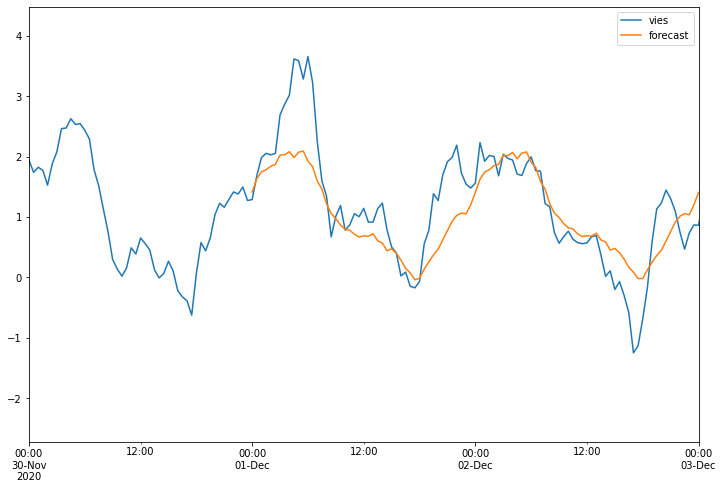

In [60]:
df['forecast'] = model.predict(start='2020-12-01', end='2020-12-03', dynamic=True)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-30', '2020-12-03'])
plt.show()

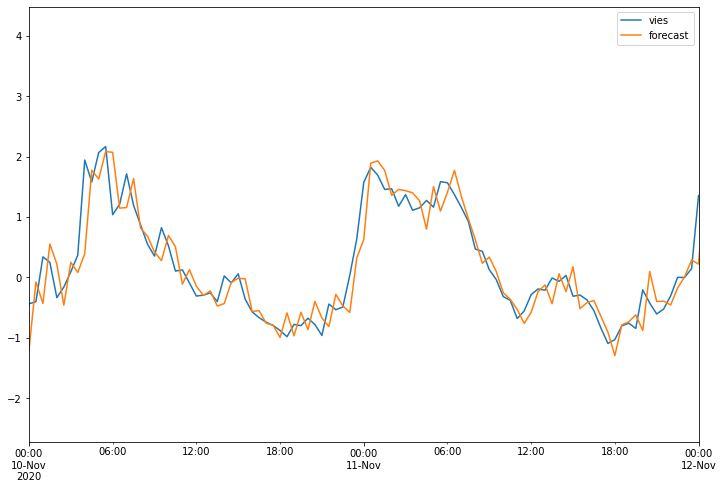

In [61]:
# Previsao in-sample 1 passo a frente
df['forecast'] = model.predict(start='2020-11-10', end='2020-11-12', dynamic=False)
df[['vies','forecast']].plot(figsize=(12,8))
plt.xlim(['2020-11-10', '2020-11-12'])
plt.show()